## Multivariate Input ,Univariate Output CNN ,Single Step

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import math

In [2]:
# Function needed

# Data Sequencing Function
def multivariate_univariate_single_step(sequence, window_size):
    x, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + window_size
        # check if we are beyond the sequence
        if end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix, :-1], sequence[end_ix - 1, -1]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

# Training Function
def training(num_epochs, train_iter, test_iter, optimiser, loss_fn, model):
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    for t in range(num_epochs):
        # Initialise hidden state
        #     Don't do this if you want your LSTM to be stateful
        #     model.hidden = model.init_hidden()
        running_loss_train = 0
        running_loss_valid = 0
        for _, (train_X, train_Y) in enumerate(train_iter):
            # Forward pass
            y_train_pred = model(train_X)

            # Reshape to perform MSE
            # y_train_pred = torch.reshape(y_train_pred, (train_Y.shape[0],1))

            loss_train = loss_fn(y_train_pred, train_Y)

            # Zero out gradient, else they will accumulate between epochs
            optimiser.zero_grad()

            # Backward pass
            loss_train.backward()

            # Update parameters
            optimiser.step()

            running_loss_train += loss_train.item()

        epoch_loss_train = running_loss_train / len(train_X)
        train_loss[t] = epoch_loss_train

        with torch.no_grad():
            for _, (test_X, test_Y) in enumerate(test_iter):
                y_test_pred = model(test_X)

                # Reshape to perform MSE
                # y_test_pred = torch.reshape(y_test_pred, (test_Y.shape[0], 1))
                loss_test = loss_fn(y_test_pred, test_Y)
                running_loss_valid += loss_test.item()

        epoch_loss_test = running_loss_valid / len(test_X)

        val_loss[t] = epoch_loss_test

    return train_loss, val_loss

## Hyperparameter

In [3]:
split_ratio = 0.70
num_epochs = 14
window_size = 4
n_step = 1
learning_rate = 0.01
# seed
torch.manual_seed(123)

## Synthetic Data

In [4]:
in_seq1 = np.array([x for x in range(0, 300, 10)])
in_seq2 = np.array([x for x in range(5, 305, 10)])
out_seq = np.array([in_seq1[i] + in_seq2[i] for i in range(len(in_seq1))])

# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))

In [5]:
split_data = round(len(dataset) * split_ratio)

# split data by indexing
train_data = dataset[:split_data]
test_data = dataset[split_data:]
print("train_data_shape")
print(train_data.shape)
print("test_data_shape")
print(test_data.shape)

train_data_shape
(21, 3)
test_data_shape
(9, 3)


## Data Normalization

In [6]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 1))
test_data_normalized = scaler.fit_transform(test_data.reshape(-1, 1))

In [7]:
# transform after scaling
train_data_normalized = train_data_normalized.reshape(train_data.shape[0], train_data.shape[1])
print("test_data_normalized" + str(train_data_normalized.shape))

test_data_normalized = test_data_normalized.reshape(test_data.shape[0], test_data.shape[1])
print("test_data_normalized" + str(test_data_normalized.shape))

test_data_normalized(21, 3)
test_data_normalized(9, 3)


## Data Sequencing

In [8]:
trainX, trainY = multivariate_univariate_single_step(train_data_normalized, window_size)
testX, testY = multivariate_univariate_single_step(test_data_normalized, window_size)
print(f"trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"testX shape:{testX.shape} testY shape:{testY.shape}")

trainX shape:(18, 4, 2) trainY shape:(18,)

testX shape:(6, 4, 2) testY shape:(6,)


## Data Transform

In [9]:
# make training and test sets in torch
trainX = torch.from_numpy(trainX).type(torch.Tensor)
trainY = torch.from_numpy(trainY).type(torch.Tensor)
testX = torch.from_numpy(testX).type(torch.Tensor)
testY = torch.from_numpy(testY).type(torch.Tensor)

In [10]:
# 3D Data Preparation
trainX = torch.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
trainY = torch.reshape(trainY, (trainY.shape[0], n_step))
testX = torch.reshape(testX, (testX.shape[0], trainX.shape[1], trainX.shape[2]))
testY = torch.reshape(testY, (testY.shape[0], n_step))


In [11]:
# Create Iterator
train_dataset = TensorDataset(trainX, trainY)
train_iter = DataLoader(train_dataset, batch_size=1, shuffle=False)

test_dataset = TensorDataset(testX, testY)
test_iter = DataLoader(test_dataset, batch_size=1, shuffle=False)

## CNN Configuration

In [12]:
class CNN_Multivariate_Univariate(nn.Module):

    def __init__(self,seq,n_step,n_timeseries):
        super(CNN_Multivariate_Univariate, self).__init__()
        self.seq=seq
        self.n_step = n_step
        self.n_timeseries = n_timeseries
        # Conv1d1d kernel_size is base on the number of time series
        self.conv1 = nn.Conv1d(in_channels=self.seq, out_channels=50, kernel_size=n_timeseries)
        # Maxpool1d kernel_size is base on the number of time series
        # For example Input:(N,C,Lin) Output : (N,C,Lout)
        self.poo1 = nn.MaxPool1d(kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=50,out_channels=40,kernel_size=1)
        self.poo2 = nn.MaxPool1d(kernel_size=1)
        self.conv3 = nn.Conv1d(in_channels=40,out_channels=30,kernel_size=1)
        self.poo3 = nn.MaxPool1d(kernel_size=1)
        self.fc1 = nn.Linear(30,20)
        self.fc2 = nn.Linear(20,10)
        self.fc3 = nn.Linear(10, n_step)

    def forward(self, x):
        x = self.poo1(F.relu(self.conv1(x)))
        x = self.poo1(F.relu(self.conv2(x)))
        x = self.poo1(F.relu(self.conv3(x)))
        # Flatten, the second argument must be the input num for the fc1
        x = x.view(-1,30)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

## Model Deployment

In [13]:
model = CNN_Multivariate_Univariate(seq=trainX.shape[1], n_step=n_step,n_timeseries=trainX.shape[2])
print(model.eval())
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

CNN_Multivariate_Univariate(
  (conv1): Conv1d(4, 50, kernel_size=(2,), stride=(1,))
  (poo1): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(50, 40, kernel_size=(1,), stride=(1,))
  (poo2): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(40, 30, kernel_size=(1,), stride=(1,))
  (poo3): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=30, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)


In [14]:
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight.data)


model.apply(weights_init)

CNN_Multivariate_Univariate(
  (conv1): Conv1d(4, 50, kernel_size=(2,), stride=(1,))
  (poo1): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(50, 40, kernel_size=(1,), stride=(1,))
  (poo2): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(40, 30, kernel_size=(1,), stride=(1,))
  (poo3): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=30, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)

## Training

In [15]:
train_loss, val_loss = training(num_epochs, train_iter, test_iter, optimizer, loss_fn, model)

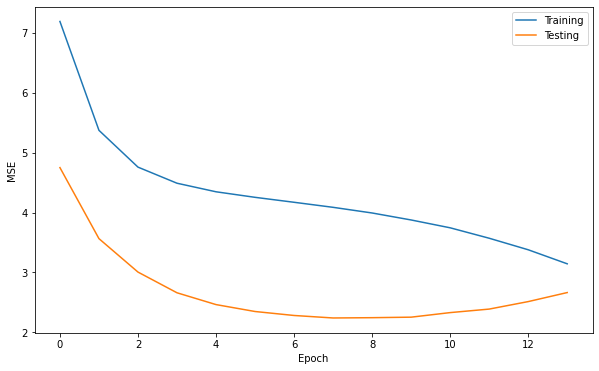

In [16]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label="Training")
plt.plot(val_loss, label="Testing")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

## Inference

In [17]:
with torch.no_grad():
    y_train_prediction = model(trainX)
    y_test_prediction = model(testX)

In [18]:
# Reshape to original data
y_train_prediction = torch.reshape(y_train_prediction,(y_train_prediction.shape[0],y_train_prediction.shape[1]))
trainY = torch.reshape(trainY,(trainY.shape[0],trainY.shape[1]))
y_test_prediction = torch.reshape(y_test_prediction,(y_test_prediction.shape[0],y_test_prediction.shape[1]))
testY = torch.reshape(testY,(testY.shape[0],testY.shape[1]))

In [19]:
#Invert predictions
y_train_prediction = scaler.inverse_transform(y_train_prediction.detach().numpy())
y_train = scaler.inverse_transform(trainY.detach().numpy())
y_test_prediction = scaler.inverse_transform(y_test_prediction.detach().numpy())
y_test = scaler.inverse_transform(testY.detach().numpy())

In [20]:
print("y-test\t\t\t\ty-predict")
for i in range(len(y_test_prediction)):
    print(f"{y_test[i]}\t\t{y_test_prediction[i]}")

y-test				y-predict
[484.99997]		[404.45697]
[505.]		[407.3284]
[525.]		[410.76492]
[545.]		[414.59625]
[565.]		[418.83127]
[585.]		[423.17807]


In [21]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_prediction[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_prediction[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 77.45 RMSE
Test Score: 124.92 RMSE


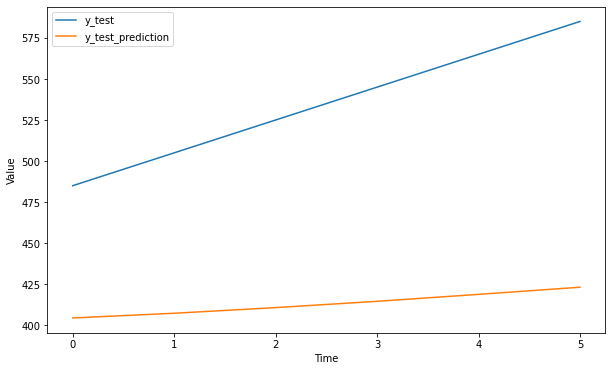

In [22]:
plt.figure(figsize=(10,6))
plt.plot(y_test, label="y_test")
plt.plot(y_test_prediction, label="y_test_prediction")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

## Exercise for Multivariate (Solution)
Predict total number of demand of orders (Target Total Orders)
Data Source : https://code.datasciencedojo.com/datasciencedojo/datasets/tree/master/Daily%20Demand%20Forecasting%20Orders

In [23]:
demand = pd.read_csv(r"..\datasets\others\Daily_Demand_Forecasting_Orders.csv",sep=';')
demand.head()

,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
0,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793,539.577
1,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,224.675
2,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412
3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120
4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517


In [24]:
demand.index.name = "Day"
demand = demand.reindex(index=range(1,len(demand)))
demand.iloc[0:5]

,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
Day,,,,,,,,,,,,,
1,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,224.675
2,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412
3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120
4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517
5,2,4,110.925,96.360,30.792,50.704,125.868,79.000,52042,8773,47522,24966,207.364


In [25]:
demand_slice = demand.iloc[:,2::]
demand_slice.iloc[0:5,:]

,Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
Day,,,,,,,,,,,
1,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,224.675
2,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412
3,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120
4,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517
5,110.925,96.360,30.792,50.704,125.868,79.000,52042,8773,47522,24966,207.364


In [26]:
demand_value = demand_slice.values
demand_value.shape

(59, 11)

In [27]:
#Hyperameter
split_ratio_demand = 0.70
num_epochs_demand  = 500
window_size_demand = 4
n_step_demand = 1
learning_rate_demand = 0.01
batch_size_demand = 2
#seed
torch.manual_seed(123)

In [28]:
split_data_demand = round(len(dataset)*split_ratio)
split_data_demand

21

In [29]:
#split data by indexing 
train_data_demand = demand_value[:-split_data_demand]
test_data_demand = demand_value[-split_data_demand:]
train_time = demand.index[:-split_data_demand]
test_time = demand.index[-split_data_demand:]
print("train_data_shape")
print(train_data_demand.shape)
print("test_data_shape")
print(test_data_demand.shape)

train_data_shape
(38, 11)
test_data_shape
(21, 11)


In [30]:
# Data Normalization
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized_demand  = scaler.fit_transform(train_data_demand.reshape(-1, 1))
test_data_normalized_demand = scaler.fit_transform(test_data_demand.reshape(-1, 1))

In [31]:
# Transform after scaling
train_data_normalized_demand = train_data_normalized_demand .reshape(train_data_demand.shape[0],train_data_demand.shape[1])
print("test_data_normalized"+str(train_data_normalized_demand.shape))

test_data_normalized_demand = test_data_normalized_demand.reshape(test_data_demand.shape[0],test_data_demand.shape[1])
print("test_data_normalized"+str(test_data_normalized_demand.shape))

test_data_normalized(38, 11)
test_data_normalized(21, 11)


In [32]:
# Data Seqeuncing

trainX_demand ,trainY_demand =  multivariate_univariate_single_step(train_data_normalized_demand,window_size_demand)
testX_demand , testY_demand = multivariate_univariate_single_step(test_data_normalized_demand,window_size_demand)
print(f"trainX_demand shape:{trainX_demand.shape} trainY_demand shape:{trainY_demand.shape}\n")
print(f"testX_demand shape:{testX_demand.shape} testX_demand shape:{testX_demand.shape}")

trainX_demand shape:(35, 4, 10) trainY_demand shape:(35,)

testX_demand shape:(18, 4, 10) testX_demand shape:(18, 4, 10)


In [33]:
#  Data Transform

# make training and test sets in torch
trainX_demand = torch.from_numpy(trainX_demand).type(torch.Tensor)
trainY_demand = torch.from_numpy(trainY_demand).type(torch.Tensor)
testX_demand = torch.from_numpy(testX_demand).type(torch.Tensor)
testY_demand = torch.from_numpy(testY_demand).type(torch.Tensor)

#3D Data Preparation
trainX_demand = torch.reshape(trainX_demand,(trainX_demand.shape[0],trainX_demand.shape[1],trainX_demand.shape[2]))
trainY_demand = torch.reshape(trainY_demand,(trainY_demand.shape[0],n_step_demand))
testX_demand = torch.reshape(testX_demand,(testX_demand.shape[0],trainX_demand.shape[1],trainX_demand.shape[2]))
testY_demand = torch.reshape(testY_demand,(testY_demand.shape[0],n_step_demand))

In [34]:
print(f"trainX_demand shape : {trainX_demand.shape}")
print(f"trainY_demand shape : {trainY_demand.shape}")
print(f"testX_demand shape  : {testX_demand.shape}")
print(f"testY_demand_demand shape : {testY_demand.shape}")

trainX_demand shape : torch.Size([35, 4, 10])
trainY_demand shape : torch.Size([35, 1])
testX_demand shape  : torch.Size([18, 4, 10])
testY_demand_demand shape : torch.Size([18, 1])


In [35]:
# Create Iterator
train_dataset_demand = TensorDataset(trainX_demand, trainY_demand)
train_iter_demand = DataLoader(train_dataset_demand,batch_size=batch_size_demand,shuffle=False)

test_dataset_demand = TensorDataset(testX_demand, testY_demand)
test_iter_demand = DataLoader(test_dataset_demand,batch_size=batch_size_demand,shuffle=False)

In [36]:
model_demand = CNN_Multivariate_Univariate(seq=trainX_demand.shape[1], n_step=n_step_demand,n_timeseries=trainX_demand.shape[2])
print(model_demand.eval())
optimizer_demand = torch.optim.SGD(model_demand.parameters(), lr=learning_rate_demand)
loss_fn_demand = nn.MSELoss()

CNN_Multivariate_Univariate(
  (conv1): Conv1d(4, 50, kernel_size=(10,), stride=(1,))
  (poo1): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(50, 40, kernel_size=(1,), stride=(1,))
  (poo2): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(40, 30, kernel_size=(1,), stride=(1,))
  (poo3): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=30, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)


In [37]:
train_loss_demand,val_loss_demand = training(num_epochs_demand,train_iter_demand,test_iter_demand,
                                           optimiser = optimizer_demand,
                                           loss_fn = loss_fn_demand,
                                            model=model_demand)

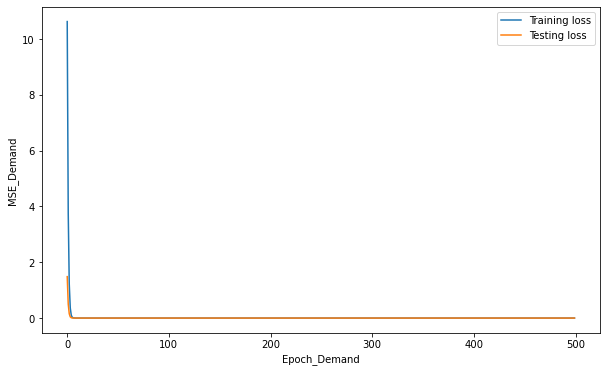

In [38]:
plt.figure(figsize=(10,6))
plt.plot(train_loss_demand, label="Training loss")
plt.plot(val_loss_demand, label="Testing loss")
plt.xlabel("Epoch_Demand")
plt.ylabel("MSE_Demand")
plt.legend()
plt.show()

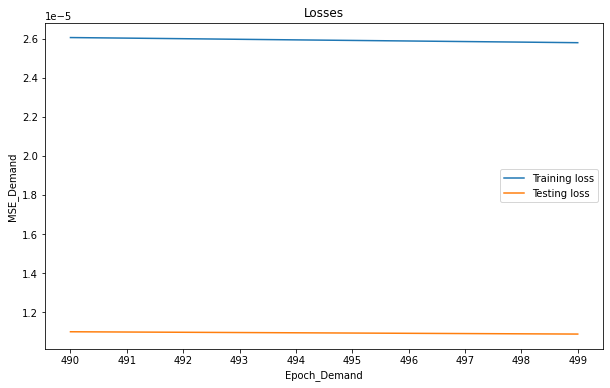

In [39]:
# Zoom in by fill in start_epoch and end_epoch
start_epoch = 490
end_epoch = 500
plt.figure(figsize=(10,6))
plt.plot(train_loss_demand[start_epoch:end_epoch], label="Training loss")
plt.plot(val_loss_demand[start_epoch:end_epoch], label="Testing loss")
plt.title("Losses")
plt.xlabel("Epoch_Demand")
plt.ylabel("MSE_Demand")
position=range(end_epoch-start_epoch)
labels=range(start_epoch,end_epoch)
plt.xticks(position, labels)
plt.legend()
plt.show()

In [40]:
# Inference 
with torch.no_grad():
    y_train_prediction_demand = model_demand(trainX_demand)
    y_test_prediction_demand = model_demand(testX_demand)

# Reshape to original data
y_train_prediction_demand = torch.reshape(y_train_prediction_demand,(y_train_prediction_demand.shape[0],y_train_prediction_demand.shape[1]))
trainY_demand = torch.reshape(trainY_demand,(trainY_demand.shape[0],trainY_demand.shape[1]))
y_test_prediction_demand = torch.reshape(y_test_prediction_demand,(y_test_prediction_demand.shape[0],y_test_prediction_demand.shape[1]))
testY_demand = torch.reshape(testY_demand,(testY_demand.shape[0],testY_demand.shape[1]))

In [41]:
#Invert predictions
y_train_prediction_demand = scaler.inverse_transform(y_train_prediction_demand.detach().numpy())
y_train_demand = scaler.inverse_transform(trainY_demand.detach().numpy())
y_test_prediction_demand = scaler.inverse_transform(y_test_prediction_demand.detach().numpy())
y_test_demand = scaler.inverse_transform(testY_demand.detach().numpy())

In [42]:
print("y-test_demand\t\t\t\ty-predict_demand")
for i in range(len(y_test_prediction_demand)):
    print(f"{y_test_demand[i]}\t\t{y_test_prediction_demand[i]}")

y-test_demand				y-predict_demand
[234.50491]		[504.32968]
[234.7216]		[306.13232]
[230.06537]		[109.361046]
[357.39624]		[232.94275]
[259.24747]		[169.49904]
[244.23564]		[254.13266]
[402.6081]		[88.21146]
[255.05988]		[196.65536]
[342.60614]		[173.08696]
[268.64056]		[257.8919]
[188.6027]		[312.48172]
[202.02213]		[143.3959]
[213.5065]		[124.62987]
[316.85074]		[212.84132]
[286.41388]		[165.79018]
[303.4464]		[343.12015]
[304.9481]		[245.47025]
[331.89783]		[413.5684]


In [43]:
print(f"y_test_demand_shape : {y_test_demand.shape}")
print(f"y_test_demand_pred_shape : {y_test_prediction_demand.shape}")

y_test_demand_shape : (18, 1)
y_test_demand_pred_shape : (18, 1)


In [44]:
# calculate root mean squared error
trainScore_demand = math.sqrt(mean_squared_error(y_train_demand[:,0], y_train_prediction_demand[:,0]))
print('Train Score: %.2f RMSE' % (trainScore_demand))
testScore_demand = math.sqrt(mean_squared_error(y_test_demand[:,0], y_test_prediction_demand[:,0]))
print('Test Score: %.2f RMSE' % (testScore_demand))

Train Score: 98.37 RMSE
Test Score: 131.46 RMSE


In [45]:
start_time =train_data_demand.shape[0]+window_size_demand
end_time = len(demand)+1

In [46]:
# Adjust to make the sequence data plot on original test data 
a=range(start_time,end_time)
a

range(42, 60)

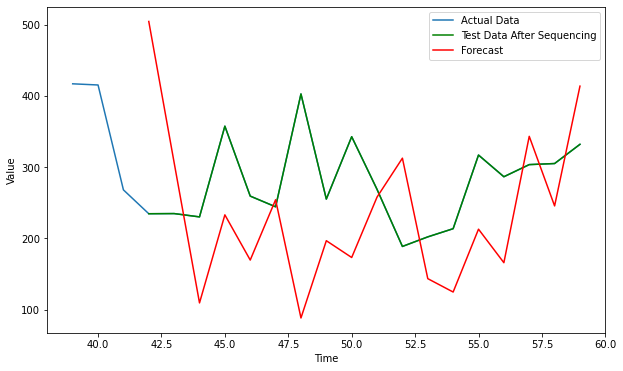

In [47]:
plt.figure(figsize=(10,6))
plt.plot(test_time,test_data_demand[:,-1], label = 'Actual Data')
plt.plot(a,y_test_demand, color="green",label = 'Test Data After Sequencing')
plt.plot(a,y_test_prediction_demand,color="red", label = 'Forecast')
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()

## Reference
1. Deep Learning for Time Series Forecasting (Predict the Future with MLPs,CNNs and LSTMs in Python) , Jason Brownlee